## Select articles: look for hateful comments

In [34]:
%load_ext autoreload
%autoreload 2
from mongoengine import connect
from hatespeech_models import Tweet, Article

client = connect("hatespeech-labelling")
db = client["hatespeech-labelling"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
Article.objects.count()

34021

In [39]:
initial_query = {
    "comments__19__exists": True,
}
articles = Article.objects(**initial_query).search_text("Coronavirus COVID cuarentena").as_pymongo()
articles = list(articles)

print(len(articles))


3453


[737440. 737460. 737480. 737500. 737520. 737540. 737560. 737580. 737600.
 737620.]


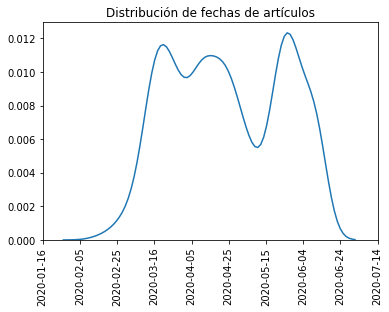

In [40]:
import seaborn as sns
import pandas as pd
import datetime
import matplotlib.pyplot as plt

dates_dist = [a["created_at"] for a in articles]
ordinal_dates = [d.toordinal() for d in dates_dist]
sns.distplot(ordinal_dates, kde=True, hist=False)

locations, _ = plt.xticks();
print(locations)
labels = [datetime.datetime.fromordinal(int(t)).date() for t in locations]

plt.xticks(locations, labels, rotation=90)
plt.title("Distribución de fechas de artículos");

In [41]:
for article in articles:
    hateful_comments = [c for c in article["comments"] if c["hateful_value"] > 0.5]
    
    article["num_hateful_comments"] = len(hateful_comments)
    article["avg_hate_value"] = sum(c["hateful_value"] for c in article["comments"]) / len(article["comments"])


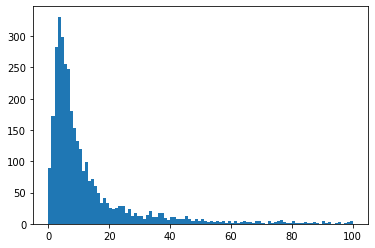

In [42]:
import matplotlib.pyplot as plt

plt.hist([c["num_hateful_comments"] for c in articles], range=[0, 100], bins=100);

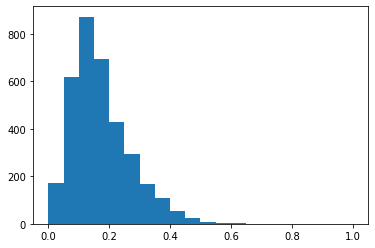

In [43]:
import matplotlib.pyplot as plt

plt.hist([c["avg_hate_value"] for c in articles], range=[0, 1], bins=20);

[737425. 737450. 737475. 737500. 737525. 737550. 737575. 737600. 737625.
 737650.]


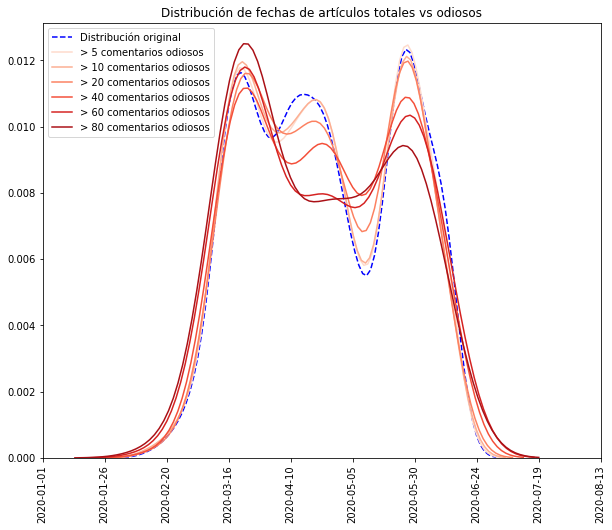

In [44]:
import random
random.seed(2020)


thresholded_hateful_articles = {
    k:[art for art in articles if art["num_hateful_comments"] >= k]
    
    for k in [5, 10, 20, 40, 60, 80]
}
len(hateful_articles)

plt.figure(figsize=(10, 8))
sns.distplot(ordinal_dates, kde=True, hist=False, color="blue", label="Distribución original", kde_kws={"linestyle": "--"})

colors = sns.color_palette("Reds", len(thresholded_hateful_articles))

for i, (k, hateful_articles) in enumerate(thresholded_hateful_articles.items()):
    hateful_dates = [art["created_at"].toordinal() for art in hateful_articles]
    sns.distplot(
        hateful_dates, kde=True, hist=False,
        label=f"> {k} comentarios odiosos",
        color=colors[i],
    )


locations, _ = plt.xticks();
print(locations)
labels = [datetime.datetime.fromordinal(int(t)).date() for t in locations]

plt.xticks(locations, labels, rotation=90)
plt.title("Distribución de fechas de artículos totales vs odiosos");

{0.1: 2662, 0.16: 1635, 0.22: 919, 0.28: 468, 0.33999999999999997: 236, 0.4: 96}
[737425. 737450. 737475. 737500. 737525. 737550. 737575. 737600. 737625.
 737650.]


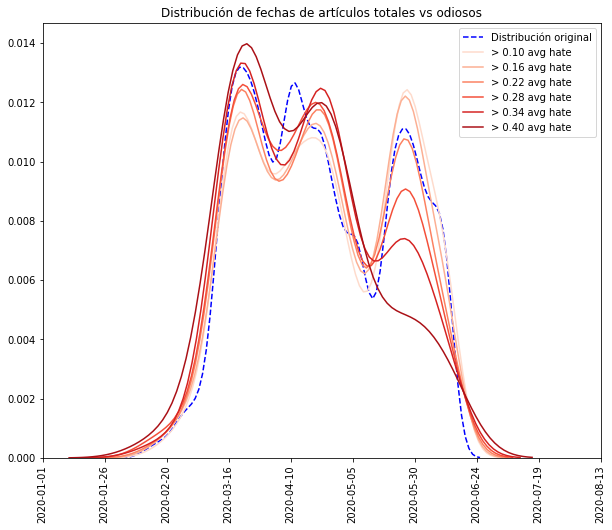

In [31]:
import random
import numpy as np

random.seed(2020)


thresholded_hateful_articles = {
    k:[art for art in articles if art["avg_hate_value"] > k]
    
    for k in np.arange(0.1, 0.45, 0.06)
}
print({k:len(art) for k, art in thresholded_hateful_articles.items()})

plt.figure(figsize=(10, 8))
sns.distplot(ordinal_dates, kde=True, hist=False, color="blue", label="Distribución original", kde_kws={"linestyle": "--"})

colors = sns.color_palette("Reds", len(thresholded_hateful_articles))

for i, (k, hateful_articles) in enumerate(thresholded_hateful_articles.items()):
    hateful_dates = [art["created_at"].toordinal() for art in hateful_articles]
    sns.distplot(
        hateful_dates, kde=True, hist=False,
        label=f"> {k:.2f} avg hate",
        color=colors[i],
    )


locations, _ = plt.xticks();
print(locations)
labels = [datetime.datetime.fromordinal(int(t)).date() for t in locations]

plt.xticks(locations, labels, rotation=90)
plt.title("Distribución de fechas de artículos totales vs odiosos");

Parecieran tener una distribución similar, aunque podemos observar que en el segundo pico no pareciera haber tanta concentración de noticias odiosas

In [32]:
import random

random.seed(2020)
#selected_articles = hateful_articles
hateful_articles = [art for art in articles if art["num_hateful_comments"] >= 3]
selected_articles = random.sample(hateful_articles, 30)

In [33]:
len_comments = sum([len(art["comments"]) for art in selected_articles])

print(len_comments)

2869


In [ ]:
from articles.models import Group
from mongoengine import DoesNotExist
try:
    group = Group.objects.get(name="random")
except DoesNotExist:
    group = Group(name="random")
    
group.tweet_ids = [art["tweet_id"] for art in selected_articles]
group.save()